# DBSCAN
基于密度的聚类算法。与划分和层次聚类方法不同，它将簇定义为密度相连的点的最大集合，能够把具有足够高密度的区域划分为簇，并可在噪声的空间数据库中发现任意形状的聚类
# 算法流程： 
1. 选取一个点，以eps为半径，画一个圈，看圈内有几个临近点？如果大于某个阈值min_points，则认为该点为某一簇的点，如果小于min_points，则被标记为噪声点，然后处理下一个点。
2. 将临近点作为种子点 seeds，遍历seeds
   * 如果该点被标记为噪声点，则重标记为聚类点
   * 如果该点没有被标记过，则标记为聚类点，并已该点为圆心，以eps为半径画圈，如果圈内点大于min_points，将圈内点，添加到种子点中
3. 重复步骤2，直到遍历完所有的种子点
4. 标记完一簇后，寻找一个未标记的点，开始新的一轮聚类

In [1]:
# 导包
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn import metrics

In [2]:
# 宏定义
UNCLASSFIED = 0 # 未分类 
NOISE = -1 # 噪声

In [3]:
# 计算数据点两两之间的距离
def getDistanceMatrix(datas): 
    N, D = np.shape(datas) 
    dists = np.zeros([N, N])

    for i in range(N):
        for j in range(N):
            vi = datas[i, :]
            vj = datas[j, :]
            dists[i, j] = np.sqrt(np.dot((vi - vj), (vi - vj)))
    return dists

In [4]:
# 寻找以cluster_id为中心，eps为半径的圆内的所以点的id
def find_points_in_eps(point_id, eps, dists): 
    index = (dists[point_id] <= eps) 
    return np.where( index == True)[0].tolist()

In [5]:
# 聚类扩展
# dists : 所有数据两两之间的距离，N x N 
# labs  : 所以数据的标签 labs N
# cluter_id : 簇的标号
# eps : 密度评估半径
# seeds : 用来进行簇扩展的点
# min_points : 半径内最少的点数
def expend_cluster(dists, labs, cluster_id, seeds, eps, min_points): 
    i = 0
    while i < len(seeds): 
        # 获取一个临近点
        Pn = seeds[i] 
        if labs[Pn] == NOISE: 
            labs[Pn] = cluster_id
        elif labs[Pn] == UNCLASSFIED: 
            labs[Pn] = cluster_id
            new_seeds = find_points_in_eps(Pn, eps, dists)

            if len(new_seeds) >= min_points: 
                seeds = seeds + new_seeds
        i = i + 1

In [6]:
# 绘图
def draw_cluster(datas, labs, n_cluster): 
    plt.cla()
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_cluster)]
    for i, lab in enumerate(labs): 
        if lab == NOISE: 
            plt.scatter(datas[i, 0], datas[i, 1], s = 16., color = (0, 0, 0))
        else: 
            plt.scatter(datas[i, 0], datas[i, 1], s = 16., color = colors[lab - 1])
    plt.show()

In [7]:
def dbscan(datas, eps, min_points): 
    # 计算所有点的距离
    dists = getDistanceMatrix(datas)
    # 标签初始化
    n_points = datas.shape[0]
    labs = [UNCLASSFIED] * n_points 

    cluster_id = 0
    # 遍历所有点
    for point_id in range(0, n_points): 
        # 如果当前点已经处理过
        if not(labs[point_id] == UNCLASSFIED): 
            continue
        # 没有处理过则计算临近点
        seeds = find_points_in_eps(point_id, eps, dists)

        # 如果临近点数量过少则标记为 NOISE
        if len(seeds) < min_points: 
            labs[point_id] = NOISE
        else: 
            # 否则就开启一轮簇的扩张
            cluster_id = cluster_id + 1
            # 标记当前点
            labs[point_id] = cluster_id
            expend_cluster(dists, labs, cluster_id, seeds, eps, min_points)
    return labs, cluster_id

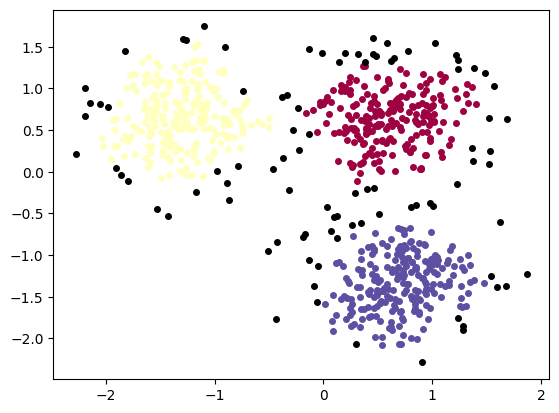

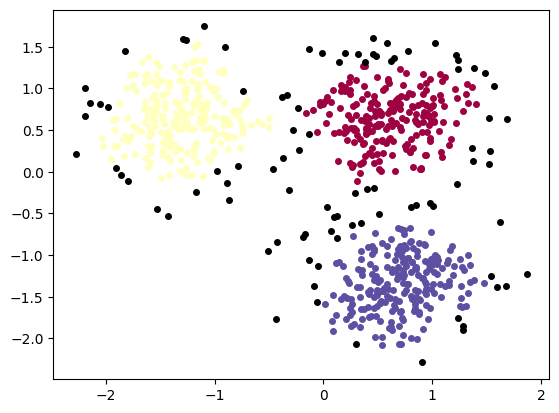

In [8]:
# 测试
# 数据生成1
centers = [[1, 1], [-1, 1], [1, -1]]
datas, labels_true = make_blobs(n_samples = 750, centers = centers, cluster_std = 0.4, random_state=0) 

# 数据生成2 
# 数据正则化
datas = StandardScaler().fit_transform(datas) 

labs, cluster_id = dbscan(datas, eps = 0.2, min_points = 10)
# print("labs of my dbscan")
# print(labs)
# print(cluster_id)
draw_cluster(datas, labs,cluster_id)

db = DBSCAN(eps = 0.45, min_samples = 5).fit(datas)
skl_labels = db.labels_
# print("labs of sk-DBSCAN")
# print(skl_labels)

draw_cluster(datas, labs, cluster_id)

In [9]:
# 生成环形数据
from sklearn.datasets import make_circles

X_train, y_train = make_circles(n_samples = 1000, factor = 0.3, noise = 0.1)
X_train = StandardScaler().fit_transform(X_train) 

In [10]:
# 绘图
def draw_test(datasets, labs, dic_colors = None, name = ''): 
    plt.cla()

    n_lab = set(labs.tolist())
    for i, val in enumerate(n_lab): 
        index = np.where( labs == val )[0]
        sub_dataset = datasets[index, : ]
        plt.scatter(sub_dataset[:, 0], sub_dataset[:, 1], s=16.,color = dic_colors[i])
    plt.title(name)
    plt.show()

dic_colors = ['r', 'g', 'b']

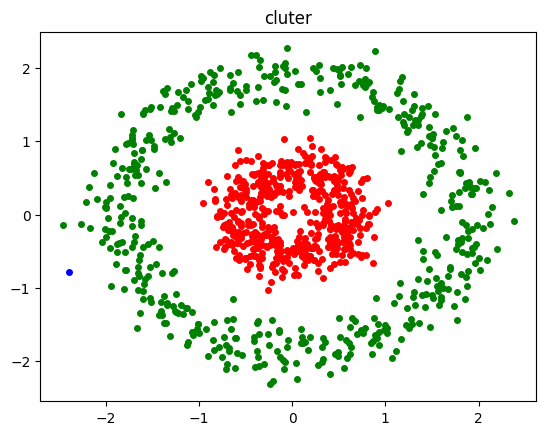

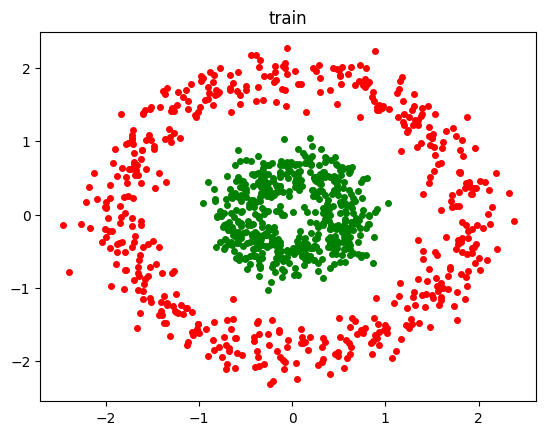

In [12]:
y_pre, cluster_id = dbscan(X_train, eps = 0.3, min_points = 5)
draw_test(X_train, np.array(y_pre), dic_colors, 'cluter')
draw_test(X_train, y_train, dic_colors, 'train')